/tmp/ipykernel_155018/357296213.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Data loaded:
                               order_id  quantity  unit_price  total_value
0  3ad45885-fb61-4145-ae6c-f10d355f4ca8         4      684.31      2737.24
1  3d5781ab-023f-42a5-81da-979e25a204ab         4      966.31      3865.24
2  4bf51692-fc33-4efb-8887-063150ffd8b4         5      182.10       910.50
3  c52331d5-67fd-452f-bdce-793e5718d806         1      842.27       842.27
4  ecf25a6a-741c-4a22-badf-61cbf2b61290         1      629.16       629.16

📊 Summary statistics:
          quantity   unit_price  total_value
count  6349.000000  6349.000000  6349.000000
mean      3.013230   544.961345  1637.189746
std       1.414152   261.416789  1155.041432
min       1.000000   100.060000   100.090000
25%       2.000000   315.020000   712.860000
50%       3.000000   544.440000  1331.840000
75%       4.000000   768.970000  2392.900000
max       5.000000   999.720000  4997.950000

🔍 Null values:
order_id       0
quantity       0
unit_price     0
total_value    0
dtype: int64


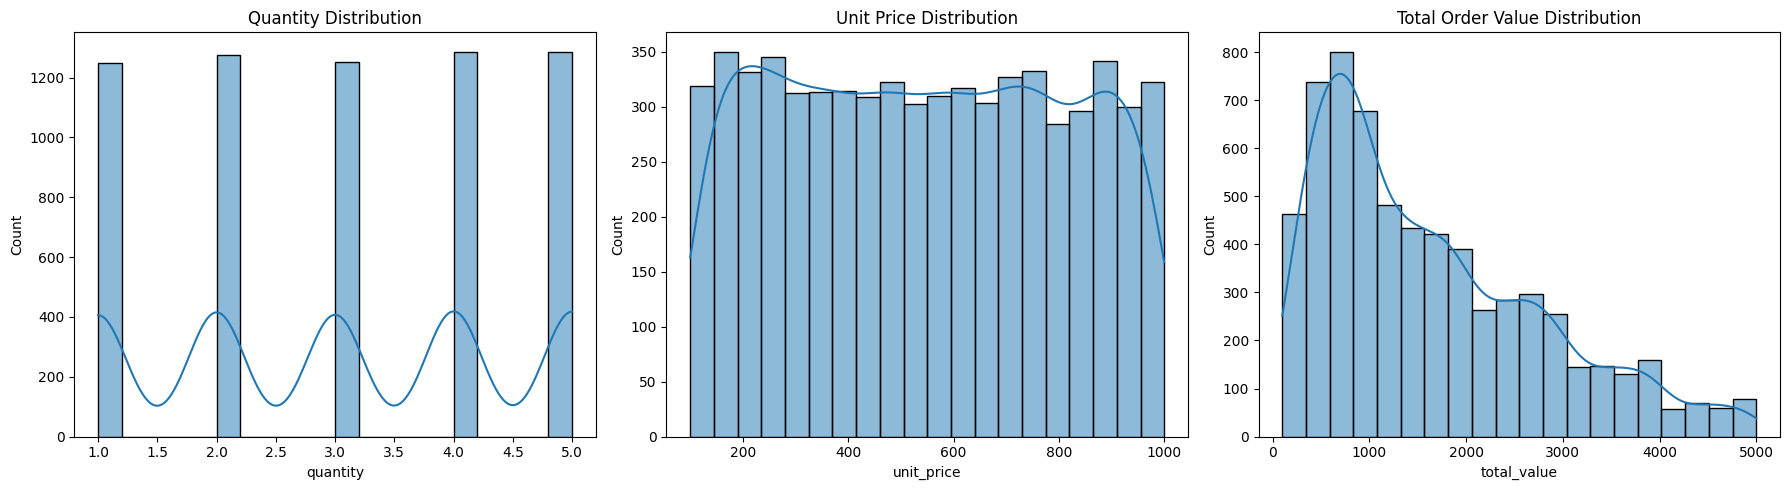

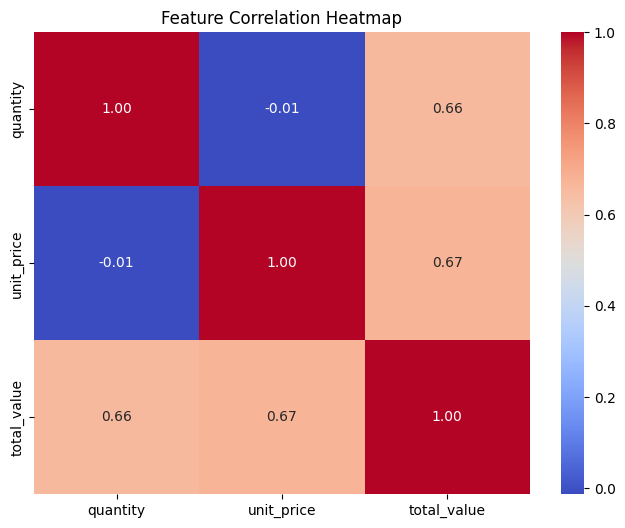

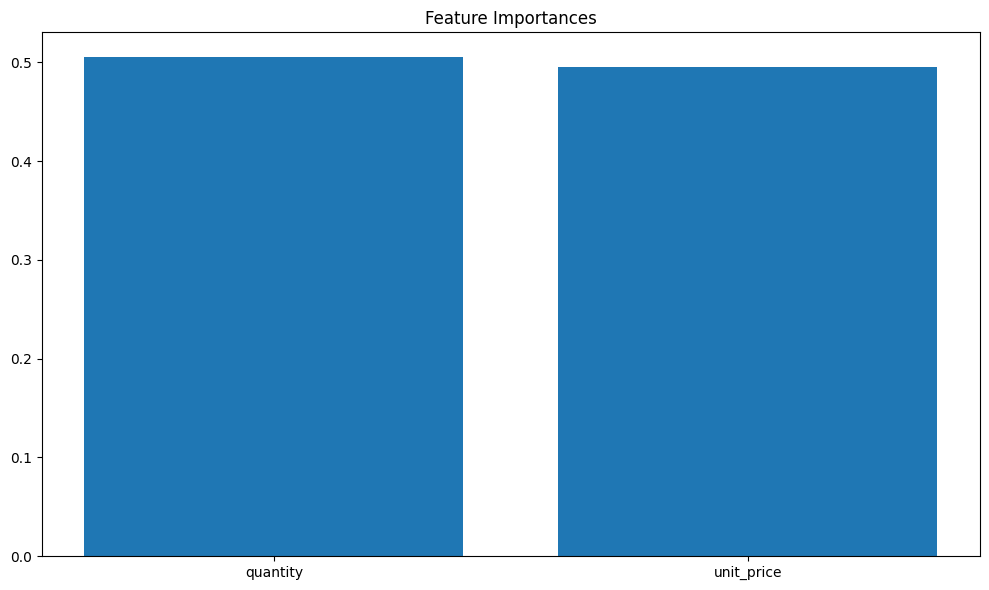

✅ Feature exploration and modeling complete!


In [ ]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname="adaptive_bi",
    user="bi_user",
    password="bi_pass",
    host="localhost",
    port="5432"
)

# Query: join orders, products, customers
query = """
SELECT 
    o.order_id, 
    o.quantity, 
    o.price AS unit_price, 
    o.price * o.quantity AS total_value,
    p.category, 
    c.location
FROM orders o
JOIN products p ON o.product_id = p.product_id
LEFT JOIN customers c ON o.customer_id = c.customer_id
"""

# Load data
df = pd.read_sql(query, conn)
print("✅ Data loaded:")
print(df.head())

# Basic statistics
print("\n📊 Summary statistics:")
print(df.describe())

# Null value check
print("\n🔍 Null values per column:")
print(df.isnull().sum())

# Optional: drop rows with nulls for modeling
df = df.dropna()

# Visualize distributions safely
if not df.empty:
    sns.histplot(df['quantity'], bins=20, kde=False)
    plt.title('Quantity Distribution')
    plt.show()

    sns.histplot(df['unit_price'], bins=20, kde=False)
    plt.title('Unit Price Distribution')
    plt.show()

    sns.histplot(df['total_value'], bins=20, kde=False)
    plt.title('Total Order Value Distribution')
    plt.show()

    # Correlation heatmap
    corr = df[['quantity', 'unit_price', 'total_value']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Heatmap')
    plt.show()

    # Encode categorical variables
    df_encoded = pd.get_dummies(df, columns=['category', 'location'], drop_first=True)

    # Feature importance with RandomForest
    from sklearn.ensemble import RandomForestRegressor

    X = df_encoded.drop(['order_id', 'total_value'], axis=1)
    y = df_encoded['total_value']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()

    print("✅ Feature exploration complete!")
else:
    print("⚠️ Warning: DataFrame is empty after loading or cleaning.")